## Variational Inference: Cascaded ODE

In this example, we use a cascaded system of ODEs.

The dataset required is small and is available preprocessed here:

- https://drive.google.com/drive/folders/1Tg_3SlKbdv0pDog6k2ys0J79e1-vgRyd?usp=sharing

In [1]:
import torch
import numpy as np
from gpytorch.optim import NGD
from torch.optim import Adam
from torch.nn import Parameter
from matplotlib import pyplot as plt

from lafomo.datasets import P53Data
from lafomo.configuration import VariationalConfiguration
from lafomo.models import OrdinaryLFM, generate_multioutput_rbf_gp
from lafomo.plot import Plotter1d, Colours
from lafomo.trainers import VariationalTrainer
from lafomo.utilities.data import p53_ground_truth

Let's start by importing our dataset...

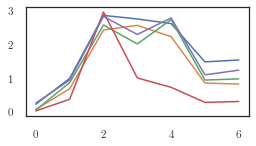

In [2]:
dataset = P53Data(replicate=0, data_dir='../../../data')
num_genes = 5
num_tfs = 1

plt.figure(figsize=(4, 2))
for i in range(5):
    plt.plot(dataset[i][1])

We use the cascaded ordinary differential equation (ODE) model:

`dy/dt = b + sf(t) - dy`

`df/dt = g(t) - λf(t)`

`g(t) ~ GP(0, k(t, t'))`

Since this is an ODE, we inherit from the `OrdinaryLFM` class.

In [34]:
from gpytorch.constraints import Positive
class TranscriptionLFM(OrdinaryLFM):
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration, **kwargs):
        super().__init__(num_outputs, gp_model, config, **kwargs)
        self.positivity = Positive()
        self.raw_decay = Parameter(0.1 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.raw_basal = Parameter(torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.raw_sensitivity = Parameter(0.2 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.raw_protein_decay = Parameter(0.1 + torch.rand(torch.Size([1, 1]), dtype=torch.float64))

    @property
    def decay_rate(self):
        return self.positivity.transform(self.raw_decay)

    @decay_rate.setter
    def decay_rate(self, value):
        self.raw_decay = self.positivity.inverse_transform(value)

    @property
    def protein_decay_rate(self):
        return self.positivity.transform(self.raw_protein_decay)

    @protein_decay_rate.setter
    def protein_decay_rate(self, value):
        self.raw_protein_decay = self.positivity.inverse_transform(value)

    @property
    def basal_rate(self):
        return self.positivity.transform(self.raw_basal)

    @basal_rate.setter
    def basal_rate(self, value):
        self.raw_basal = self.positivity.inverse_transform(value)

    @property
    def sensitivity(self):
        return self.positivity.transform(self.raw_sensitivity)

    @sensitivity.setter
    def sensitivity(self, value):
        self.raw_sensitivity = self.decay_constraint.inverse_transform(value)

    def initial_state(self):
        h0 = torch.cat([
            torch.zeros_like(self.basal_rate),
            self.basal_rate / self.decay_rate
        ], -1)
        return h0

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        #     print(t)
        f = h[:, :, 0].unsqueeze(-1)
        y = h[:, :, 1].unsqueeze(-1)
        g = self.f[:, :, self.t_index].unsqueeze(-1)

        df = g - self.protein_decay_rate * f
        dy = self.basal_rate + self.sensitivity * f - self.decay_rate * y
        # print('df, dy', df.shape, dy.shape)

        if t > self.last_t:
            self.t_index += 1
        self.last_t = t
        return torch.cat([df, dy], -1)

    def decode(self, h_out):
        return h_out[:, :, 1]

In [35]:
config = VariationalConfiguration(
    preprocessing_variance=dataset.variance,
    num_samples=80,
    initial_conditions=False
)

num_inducing = 12  # (I x m x 1)
inducing_points = torch.linspace(0, 12, num_inducing).repeat(num_tfs, 1).view(num_tfs, num_inducing, 1)
t_predict = torch.linspace(0, 14, 80, dtype=torch.float32)
step_size = 5e-1
num_training = dataset.m_observed.shape[-1]
use_natural = True
gp_model = generate_multioutput_rbf_gp(num_tfs, inducing_points, gp_kwargs=dict(natural=use_natural))

lfm = TranscriptionLFM(num_genes, gp_model, config, num_training_points=num_training)
plotter = Plotter(lfm, dataset.gene_names, style='seaborn')

In [36]:
class P53ConstrainedTrainer(VariationalTrainer):
    def after_epoch(self):
        with torch.no_grad():
            sens = torch.tensor(1.)
            dec = torch.tensor(0.8)
            self.lfm.raw_sensitivity[3] = self.lfm.positivity.inverse_transform(sens)
            self.lfm.raw_decay[3] = self.lfm.positivity.inverse_transform(dec)
        super().after_epoch()

track_parameters = [
    'raw_basal',
    'raw_decay',
    'raw_sensitivity',
    'gp_model.covar_module.raw_lengthscale',
]
if use_natural:
    variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.1)
    parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.02)
    optimizers = [variational_optimizer, parameter_optimizer]
else:
    optimizers = [Adam(lfm.parameters(), lr=0.03)]
trainer = P53ConstrainedTrainer(lfm, optimizers, dataset, track_parameters=track_parameters)

### Outputs prior to training:

Text(0.5, 1.0, 'Latent')

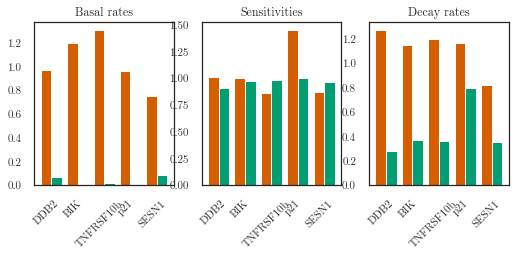

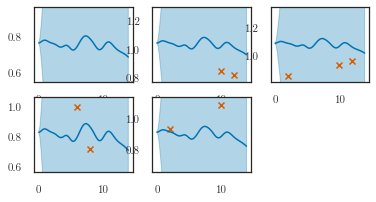

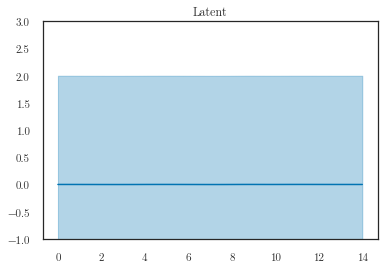

In [37]:
labels = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = list()
for key in ['raw_basal', 'raw_sensitivity', 'raw_decay']:
    kinetics.append(
        lfm.positivity.transform(trainer.parameter_trace[key][-1].squeeze()).numpy())

plotter.plot_double_bar(kinetics, labels, p53_ground_truth())
q_m = lfm.predict_m(t_predict, step_size=1e-1)
q_f = lfm.predict_f(t_predict)

plotter.plot_gp(q_m, t_predict, replicate=0,
                t_scatter=dataset.t_observed,
                y_scatter=dataset.m_observed, num_samples=0)
plotter.plot_gp(q_f, t_predict, ylim=(-1, 3))
plt.title('Latent')


In [38]:
lfm.train()
step_size = 5e-1
trainer.train(400, report_interval=10, step_size=step_size)

Epoch 001/400 - Loss: 8.05 (8.05 0.00) kernel: [[[0.6831972]]]
Epoch 011/400 - Loss: 6.91 (6.72 0.20) kernel: [[[0.64821184]]]
Epoch 021/400 - Loss: 6.50 (6.20 0.29) kernel: [[[0.6926837]]]
Epoch 031/400 - Loss: 6.17 (5.78 0.39) kernel: [[[0.7271107]]]
Epoch 041/400 - Loss: 5.94 (5.46 0.49) kernel: [[[0.7611752]]]
Epoch 051/400 - Loss: 5.67 (5.08 0.59) kernel: [[[0.78659075]]]
Epoch 061/400 - Loss: 5.34 (4.65 0.69) kernel: [[[0.7966792]]]
Epoch 071/400 - Loss: 5.10 (4.31 0.79) kernel: [[[0.7895178]]]
Epoch 081/400 - Loss: 4.75 (3.85 0.90) kernel: [[[0.8078595]]]
Epoch 091/400 - Loss: 4.54 (3.54 1.00) kernel: [[[0.81419265]]]
Epoch 101/400 - Loss: 4.16 (3.07 1.10) kernel: [[[0.8313144]]]
Epoch 111/400 - Loss: 3.87 (2.67 1.20) kernel: [[[0.8285034]]]
Epoch 121/400 - Loss: 3.61 (2.33 1.28) kernel: [[[0.84601974]]]
Epoch 131/400 - Loss: 3.29 (1.91 1.38) kernel: [[[0.8509802]]]
Epoch 141/400 - Loss: 3.05 (1.58 1.47) kernel: [[[0.8652556]]]
Epoch 151/400 - Loss: 2.68 (1.10 1.58) kernel: [[[0

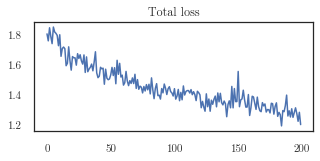

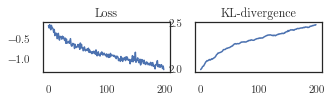

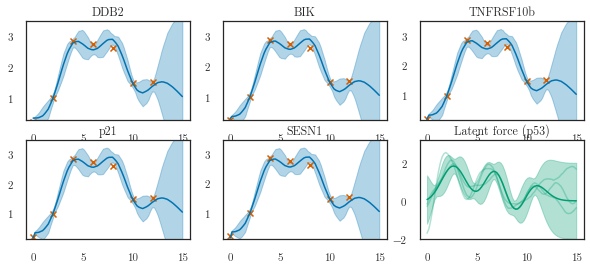

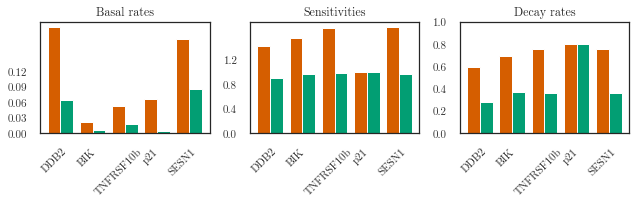

In [39]:
tight_kwargs = dict(bbox_inches='tight', pad_inches=0)
t_predict = torch.linspace(0, 15, 80, dtype=torch.float32)

lfm.eval()
q_m = lfm.predict_m(t_predict, step_size=step_size)
q_f = lfm.predict_f(t_predict)

plotter.plot_losses(trainer, last_x=200)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 4))

row = 0
col = 0
for i in range(num_genes):
    if i == 3:
        row += 1
        col = 0
    ax = axes[row, col]
    plotter.plot_gp(q_m, t_predict, replicate=0, ax=ax,
                    color=Colours.line_color, shade_color=Colours.shade_color,
                    t_scatter=dataset.t_observed, y_scatter=dataset.m_observed, num_samples=0)
    col += 1
    ax.set_title(dataset.gene_names[i])
plotter.plot_gp(q_f, t_predict, ax=axes[1, 2],
                ylim=(-2, 3.2),
                num_samples=3,
                color=Colours.line2_color,
                shade_color=Colours.shade2_color)
axes[1, 2].set_title('Latent force (p53)')
plt.savefig('./combined.pdf', **tight_kwargs)

labels = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = list()
for key in ['raw_basal', 'raw_sensitivity', 'raw_decay']:
    kinetics.append(
        lfm.positivity.transform(trainer.parameter_trace[key][-1].squeeze()).numpy())

plotter.plot_double_bar(kinetics, labels, p53_ground_truth(),
                        figsize=(9, 3),
                        yticks=[
                            np.linspace(0, 0.12, 5),
                            np.linspace(0, 1.2, 4),
                            np.arange(0, 1.1, 0.2),
                        ])
plt.tight_layout()
plt.savefig('./kinetics.pdf', **tight_kwargs)

In [ ]:
 # key in ['basal_rate', 'sensitivity', 'decay_rate']:
plt.plot(lfm.positivity.transform(torch.stack(trainer.parameter_trace['raw_basal'])[:, 3]))
plt.tight_layout()

In [ ]:
print(lfm.basal_rate)